In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole, dipole_map, spherical_to_cartesian

### fit to CMB dipole

In [3]:
# Quaia map
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
map_quaia = tools.load_catalog_as_map(cat_fn, frame='icrs')

In [4]:
# selection function
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))

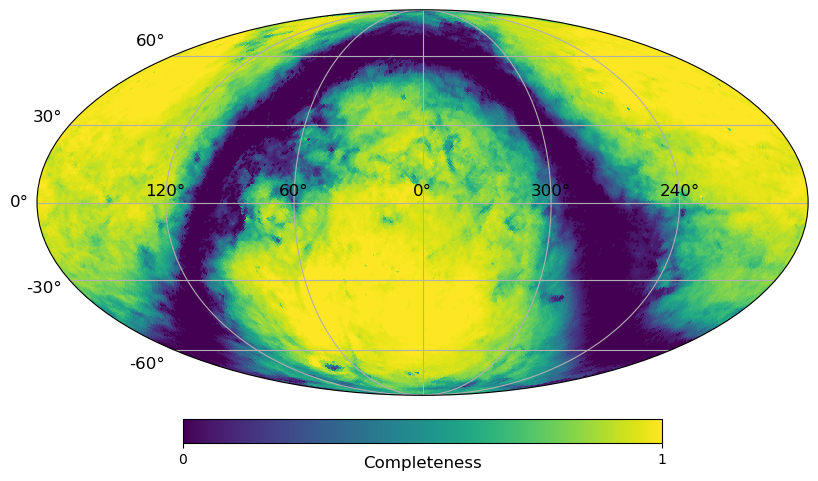

In [5]:
tools.plot_map(selfunc, unit='Completeness')

In [6]:
# CMB dipole
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
cmb_amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(cmb_amps, NSIDE) # match NSIDE with Quaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


### fit to CMB dipole and feature maps

In [7]:
# design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree

In [8]:
# weights
"""
WARNING: "magic number"
"""
# ! OLD covariance
# Cinv = 42 * selfunc

Cinv = 1. / np.clip(42 * selfunc, 1., None)  # set min value to 1

In [9]:
maps_forsel = []
map_names = ['dust', 'stars', 'm10', 'mcs']
for map_name in map_names:
    maps_forsel.append(np.load(f'/scratch/aew492/quasars/maps/map_{map_name}_NSIDE{NSIDE}.npy'))

In [10]:
# construct design matrix
fit_everything = True
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 6)

In [11]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [12]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [13]:
x_names = np.append(['completeness','CMB dipole * comp.'], map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.043264       	0.042055        	
CMB dipole * comp.	71.929164       	8.422380        	
dust            	4.530e-03       	1.539e-03       	
stars           	1.996e-05       	8.600e-06       	
m10             	-5.606e-03      	7.691e-04       	
mcs             	1.388e-04       	1.738e-04       	


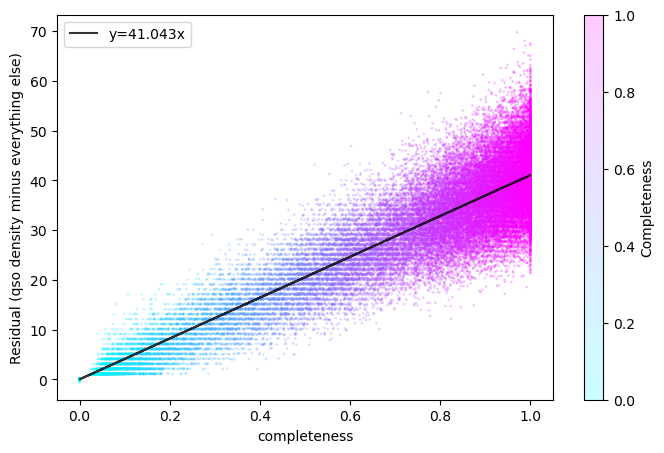

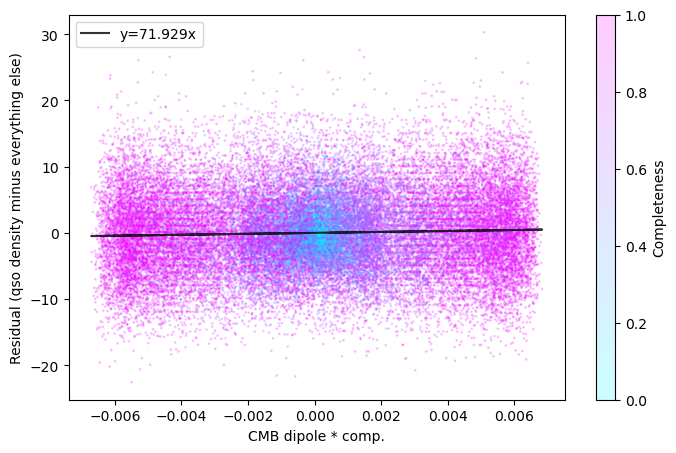

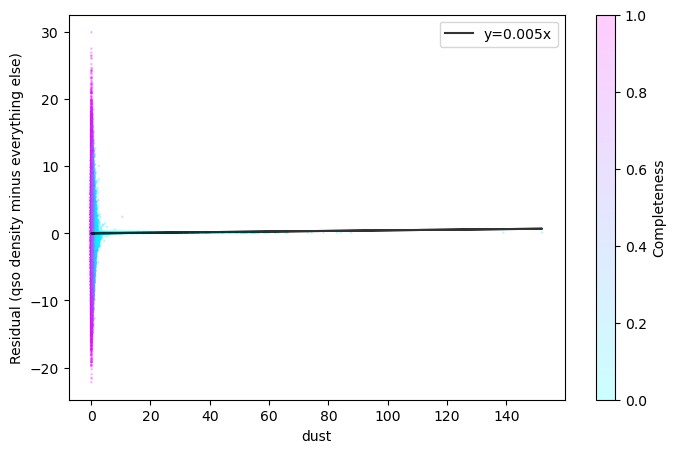

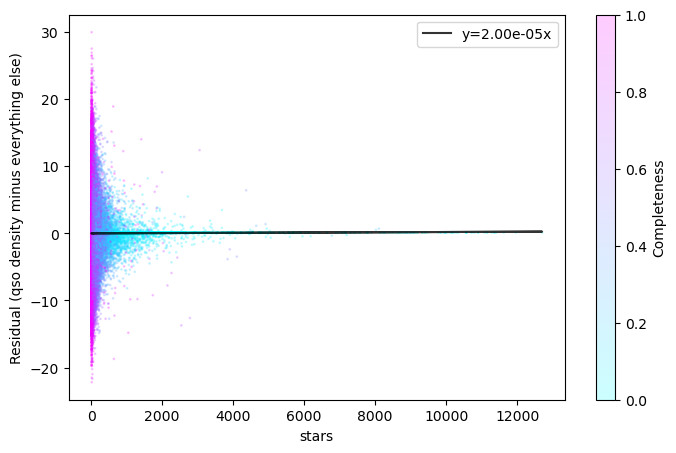

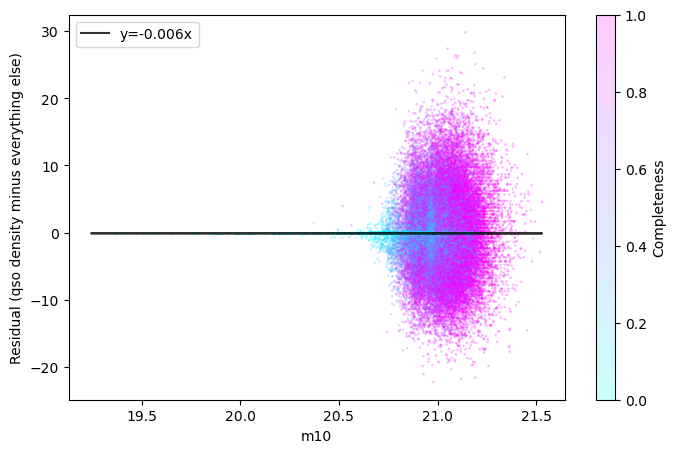

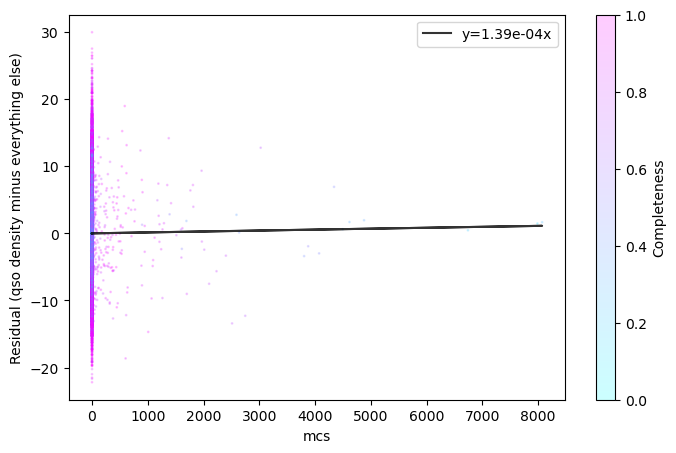

In [14]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    if x_names[i]=='stars' or x_names[i]=='mcs':
        label = f'y={slope:.2e}x'
    else:
        label = f'y={slope:.3f}x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend()
    fig.colorbar(s, label='Completeness')

### freeze the error model and refit just the CMB dipole

** what about this is "freezing the error model"? aren't we just fitting to only the CMB dipole like normal, forgetting any info from the simultaneous fit to the four feature maps?

In [15]:
# construct design matrix
fit_everything = False
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 2)

In [16]:
# perform the regression
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [17]:
x_names = ['completeness','CMB dipole * comp.']
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.6f}'
            if i >= 3:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	40.889333       	0.036432        	
CMB dipole * comp.	72.615097       	8.421875        	


### fit to the full dipole vector, without the feature maps

In [18]:
# check out three orthogonal dipole maps
template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3))))  # first column for the monopole
template_amps

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [19]:
template_maps = np.array([dipole_map(amps) for amps in template_amps])

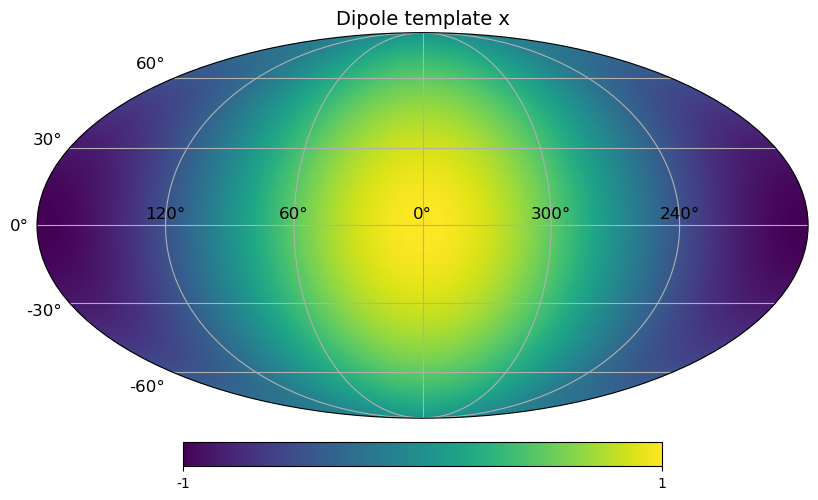

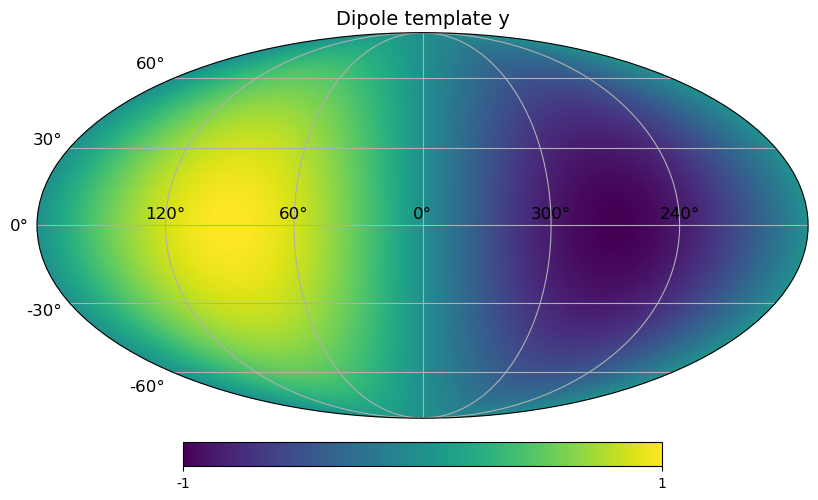

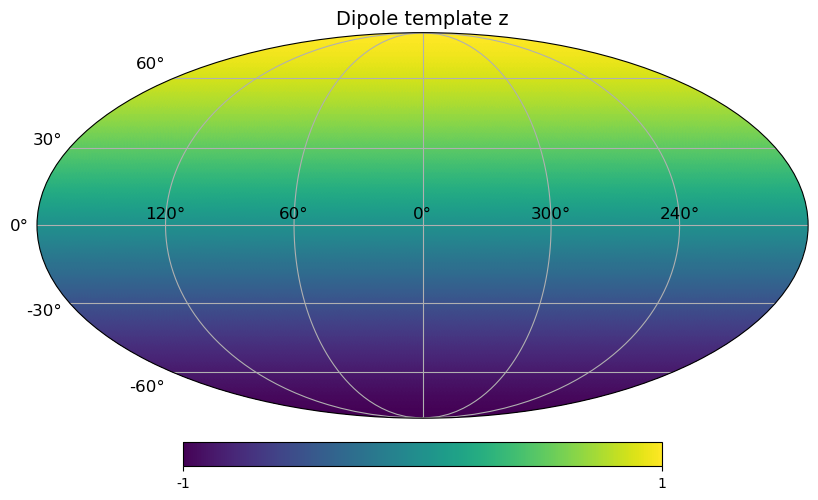

In [20]:
coords = ['x', 'y', 'z']
for i, map_ in enumerate(template_maps):
    tools.plot_map(map_, title='Dipole template '+coords[i], min=-1.0, max=1.)

In [21]:
# now get the orthogonal component maps of the CMB dipole
cmb_template_amps = cmb_amps * template_amps
cmb_template_maps = np.array([dipole_map(amps) for amps in cmb_template_amps])

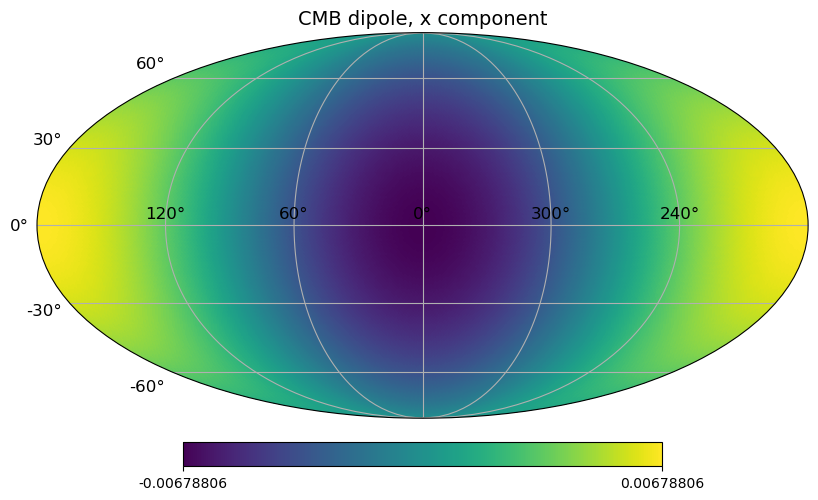

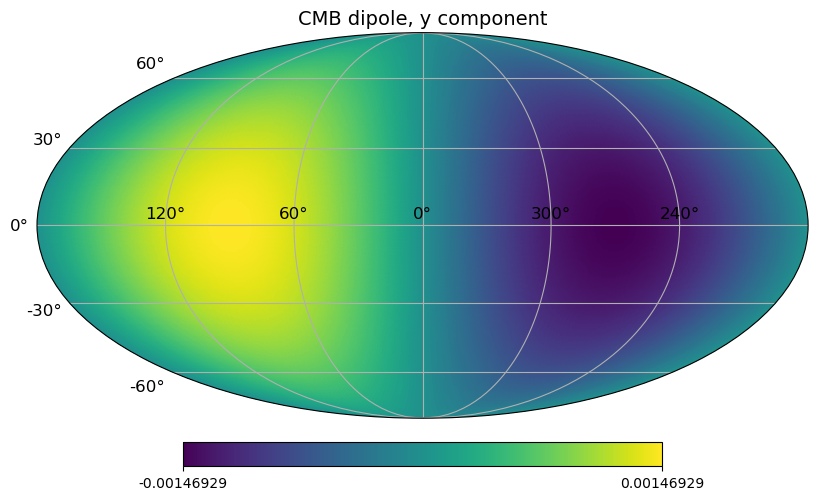

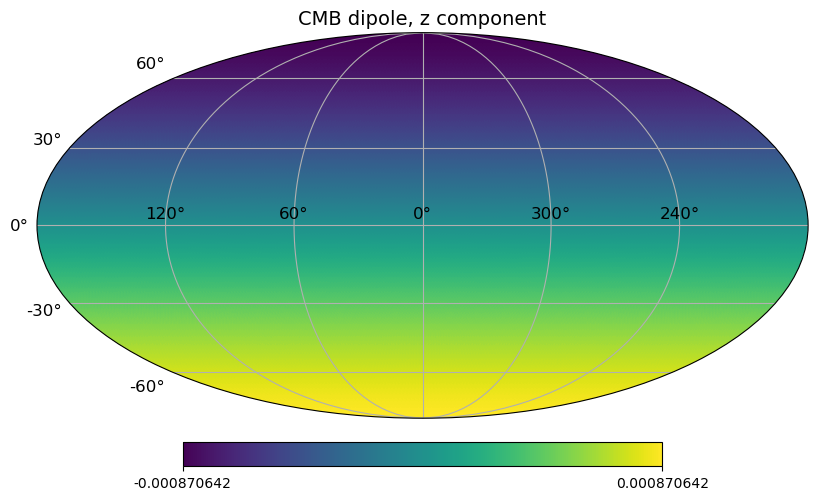

In [22]:
for i, cmbmap in enumerate(cmb_template_maps):
    tools.plot_map(cmbmap, title=f'CMB dipole, {coords[i]} component')

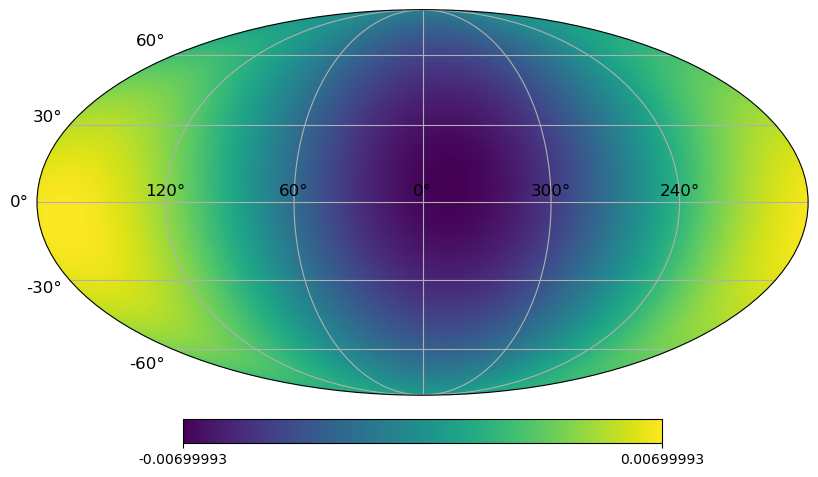

In [23]:
# check that the sum is actually the CMB dipole
cmbmap = np.sum(cmb_template_maps, axis=0)
tools.plot_map(cmbmap)

In [24]:
cmb_template_maps.shape

(3, 49152)

In [25]:
# construct design matrix
fit_everything = False
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), template_maps.T))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 4)

In [26]:
# perform the fit
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [27]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [28]:
x_names = np.append(['completeness'],[f'dipole {coord} * comp.' for coord in coords])
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	40.9395         	0.0365          	
dipole x * comp.	-0.7655         	0.0581          	
dipole y * comp.	-1.6690         	0.0705          	
dipole z * comp.	-0.7949         	0.0666          	


In [29]:
bestfit_pars[1:]

array([-0.76545288, -1.66903832, -0.79487631])

In [30]:
amp = np.linalg.norm(bestfit_pars[1:])
amp

2.000858661850306

In [31]:
direction = hp.vec2dir(bestfit_pars[1:])
ra = direction[1]
dec = np.pi/2 - direction[0]
print(((ra + 2*np.pi) * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

245.36290498438544 deg -23.407473357541992 deg


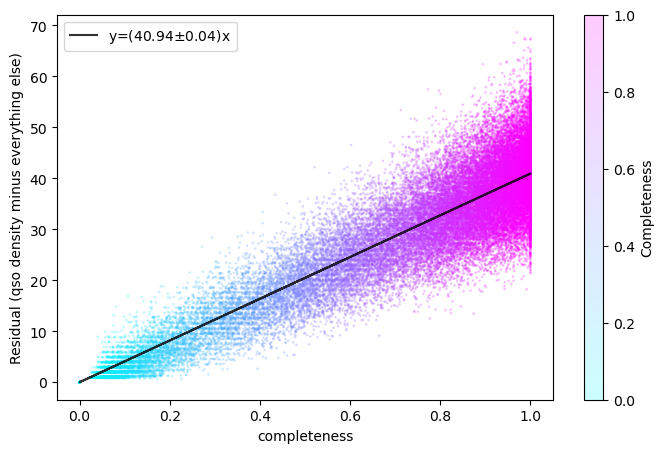

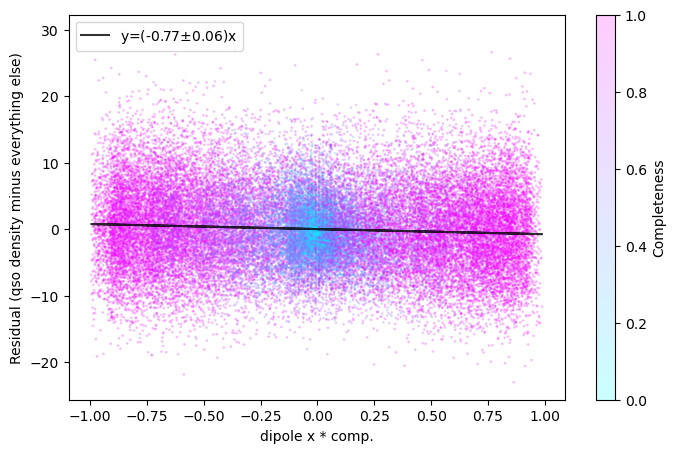

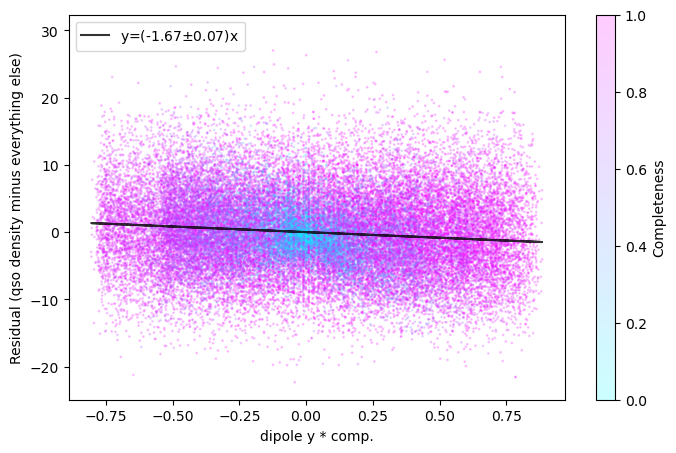

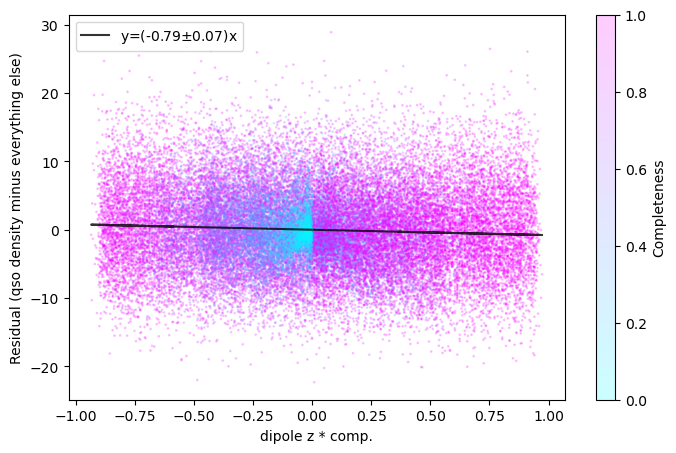

In [32]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    label = f'y=({slope:.2f}$\pm${bestfit_stderr[i]:.2f})x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend(loc=2)
    fig.colorbar(s, label='Completeness')

In [33]:
np.sum(bestfit_pars[1:])

-3.2293675143292875

### fit to the full dipole vector, with the four feature maps

In [34]:
# construct design matrix
fit_everything = True
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), template_maps.T))
if fit_everything:
    for map_ in maps_forsel:
        A = np.column_stack((A, map_))  
A.shape

(49152, 8)

In [35]:
# perform the fit
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia, A, Cinv)

In [36]:
# uncertainties on the best-fit pars
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [37]:
x_names = np.append(['completeness'], [f'dipole {coord} * comp.' for coord in coords])
x_names = np.append(x_names, map_names)
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
            if i >= 5:
                x = f'{float(entry):.3e}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.1003         	0.0421          	
dipole x * comp.	-0.7620         	0.0581          	
dipole y * comp.	-1.6784         	0.0705          	
dipole z * comp.	-0.7987         	0.0667          	
dust            	4.967e-03       	1.539e-03       	
stars           	1.650e-05       	8.601e-06       	
m10             	-5.827e-03      	7.691e-04       	
mcs             	1.218e-04       	1.740e-04       	


In [38]:
amp = np.linalg.norm(bestfit_pars[1:])
direction = hp.vec2dir(bestfit_pars[1:4])
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
print(((ra + 2*np.pi) * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

2.008891764190637
245.58297995523762 deg -23.42776090436013 deg


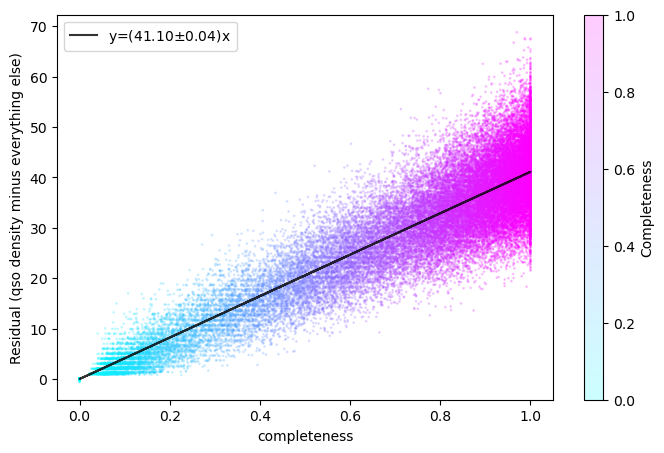

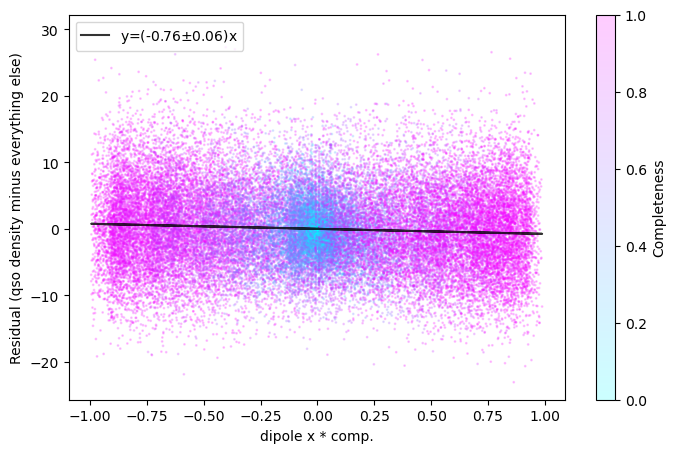

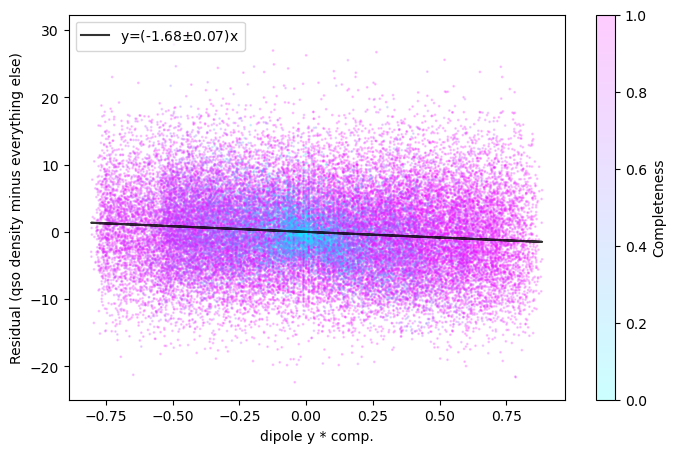

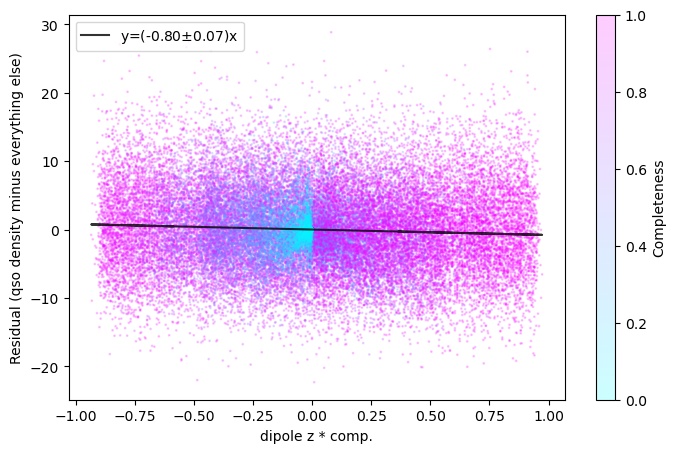

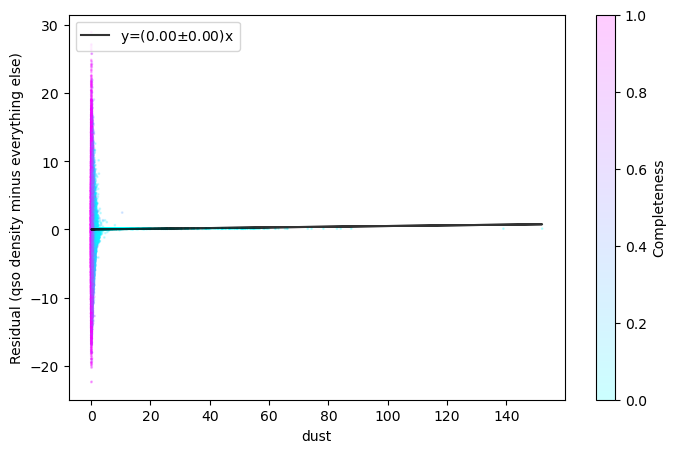

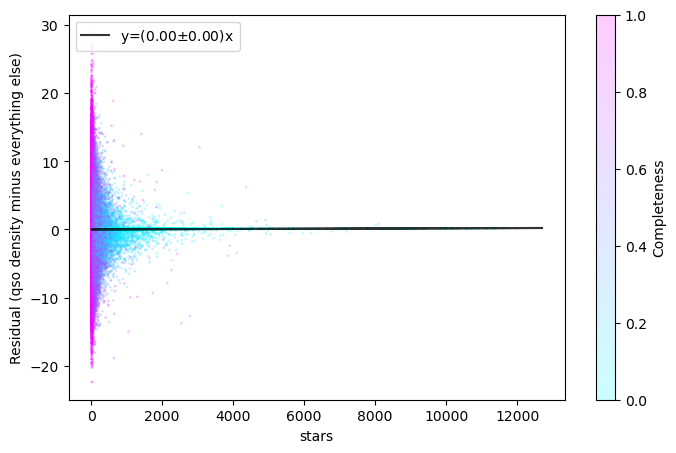

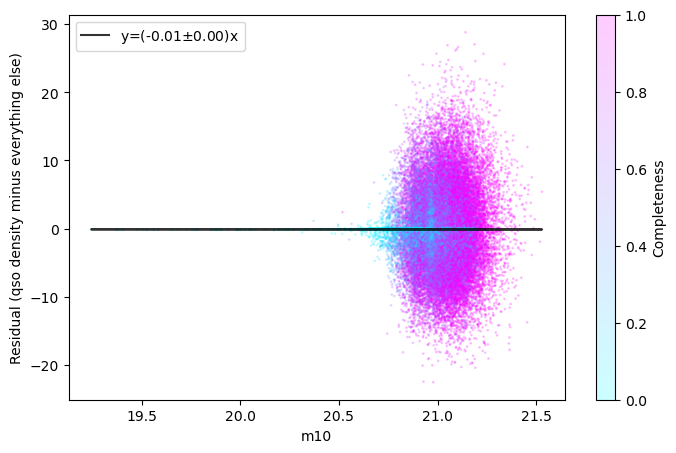

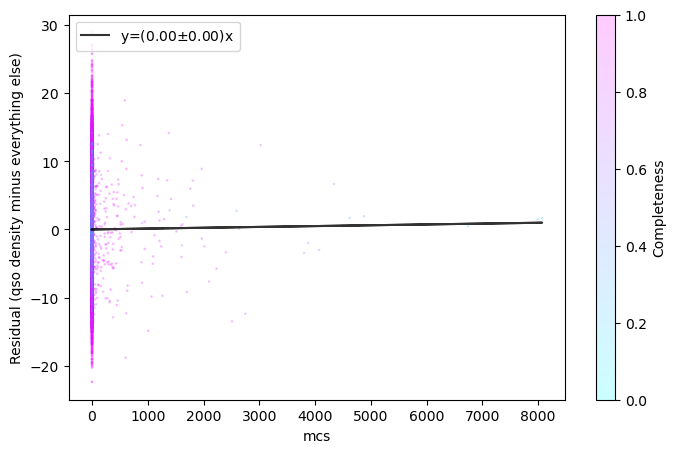

In [39]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    label = f'y=({slope:.2f}$\pm${bestfit_stderr[i]:.2f})x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend(loc=2)
    fig.colorbar(s, label='Completeness')

### fit to the full dipole vector, only where completeness > 0.9

In [40]:
idx_clean = np.where(selfunc > 0.9)
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), template_maps.T))
# only include the clean (comp>0.9) pixels in the fit
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia[idx_clean], A[idx_clean], Cinv[idx_clean])
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [41]:
x_names = np.append(['completeness'],[f'dipole {coord} * comp.' for coord in coords])
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.2011         	0.0521          	
dipole x * comp.	-0.3488         	0.0936          	
dipole y * comp.	-0.5204         	0.1217          	
dipole z * comp.	-0.0282         	0.1156          	


In [42]:
amp = np.linalg.norm(bestfit_pars[1:])
direction = hp.vec2dir(bestfit_pars[1:4])
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
print(((ra + 2*np.pi) * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

0.6270572138506089
236.16960833703234 deg -2.5800967500759002 deg


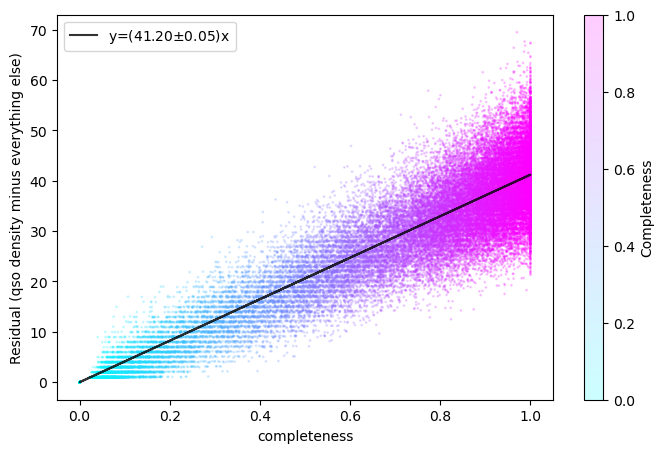

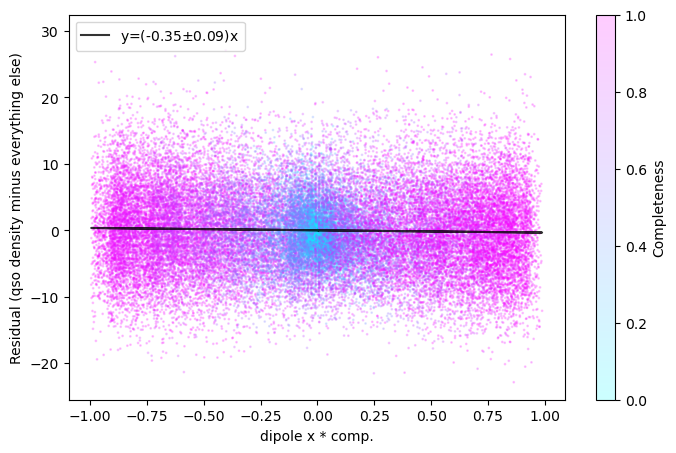

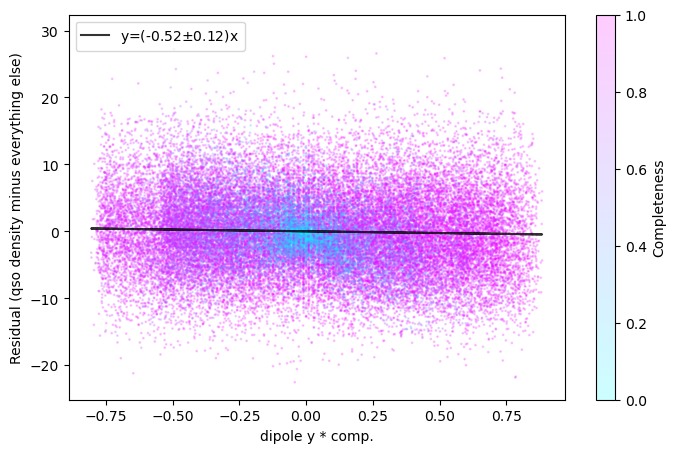

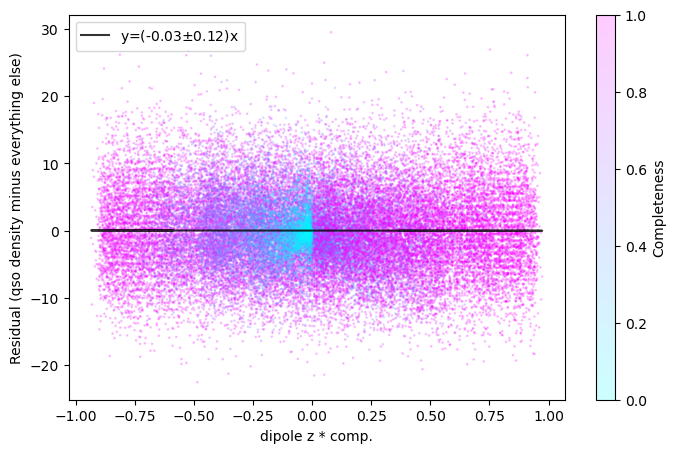

In [43]:
for i, slope in enumerate(bestfit_pars):
    pars_copy = bestfit_pars.copy()
    pars_copy[i] = 0
    plot_y = map_quaia - A @ pars_copy
    label = f'y=({slope:.2f}$\pm${bestfit_stderr[i]:.2f})x'
    fig, ax = plt.subplots(figsize=(8,5))
    s = ax.scatter(A[:,i], plot_y, marker='.', s=4, ls='None', c=selfunc, cmap='cool', alpha=0.2)
    ax.plot(A[:,i], slope * A[:,i], color='k', alpha=0.8, label=label, zorder=100)
    ax.set_xlabel(x_names[i])
    ax.set_ylabel('Residual (qso density minus everything else)')
    # ax.set_title('Dipole fit to Quaia catalog')
    ax.legend(loc=2)
    fig.colorbar(s, label='Completeness')

### fit with the same mask as Secrest

In [44]:
galactic_mask = tools.get_galactic_mask(blim=30, NSIDE=64, frame='icrs')

In [47]:
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), template_maps.T))
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia[galactic_mask], A[galactic_mask], Cinv[galactic_mask])
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [48]:
x_names = np.append(['completeness'],[f'dipole {coord} * comp.' for coord in coords])
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.3085         	0.0435          	
dipole x * comp.	-0.5919         	0.0694          	
dipole y * comp.	-0.5626         	0.0962          	
dipole z * comp.	-0.3229         	0.0892          	


In [49]:
amp = np.linalg.norm(bestfit_pars[1:])
direction = hp.vec2dir(bestfit_pars[1:4])
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
print(((ra + 2*np.pi) * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

0.8781358064481835
223.54961096698213 deg -21.571341873999383 deg


In [60]:
# mask mcs?
map_mc = np.copy(maps_forsel[3]).astype('float')
mcs_mask = (map_mc <= 0)
map_mc[mcs_mask] = np.nan

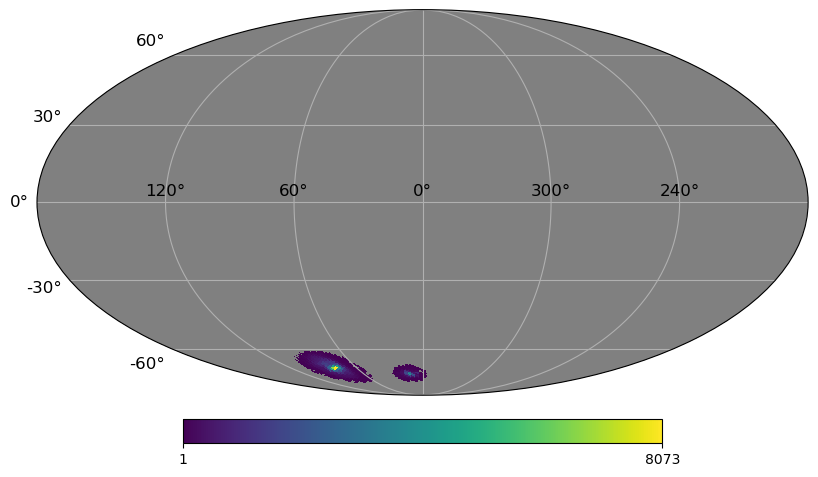

In [61]:
tools.plot_map(map_mc)

In [65]:
idx_to_fit = galactic_mask & mcs_mask

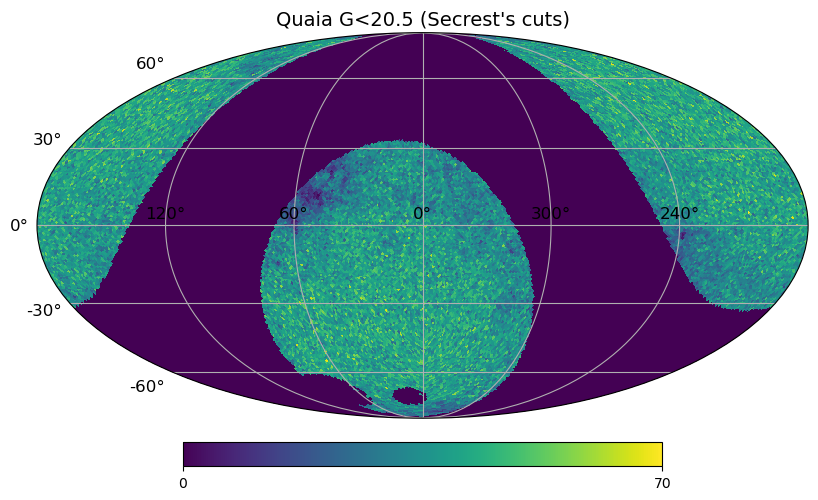

In [73]:
tools.plot_map(map_quaia * idx_to_fit, title=f'Quaia G<{G} (Secrest\'s cuts)')

In [74]:
bestfit_pars, bestfit_Cinv = tools.lstsq(map_quaia[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit])
bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

In [75]:
x_names = np.append(['completeness'],[f'dipole {coord} * comp.' for coord in coords])
headings = ['feature:', 'best fit:', 'std err:']
print_arr = np.row_stack((headings, np.column_stack((x_names, bestfit_pars, bestfit_stderr))))
for i, row in enumerate(print_arr):
    print_str = ''
    for entry in row:
        try:
            x = f'{float(entry):.4f}'
        except:
            x = str(entry)
        print_str += f'{x:16s}\t'
    print(print_str)

feature:        	best fit:       	std err:        	
completeness    	41.3126         	0.0437          	
dipole x * comp.	-0.5969         	0.0695          	
dipole y * comp.	-0.5602         	0.0963          	
dipole z * comp.	-0.3390         	0.0909          	


In [76]:
amp = np.linalg.norm(bestfit_pars[1:])
direction = hp.vec2dir(bestfit_pars[1:4])
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
print(((ra + 2*np.pi) * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

0.8860328357131088
223.18112803403633 deg -22.497196911655347 deg


### double check trivial healpy.fit_dipole

In [84]:
map_quaia_nodipole, hp_monopole, hp_dipole = hp.remove_dipole(map_quaia.astype('float'), fitval=True)
hp_monopole, hp_dipole

(26.3570556640625, array([-1.76606626,  1.28868163,  0.42642223]))

In [85]:
print(np.linalg.norm(hp_dipole))
direction = hp.vec2dir(hp_dipole)
print(direction)
ra = direction[1]
dec = np.pi/2 - direction[0]
print((ra * u.rad).to(u.deg), (dec*u.rad).to(u.deg))

2.227448386941718
[1.37816748 2.51121688]
143.8821288608461 deg 11.036819997737298 deg


In [88]:
cmb_dipdir.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>

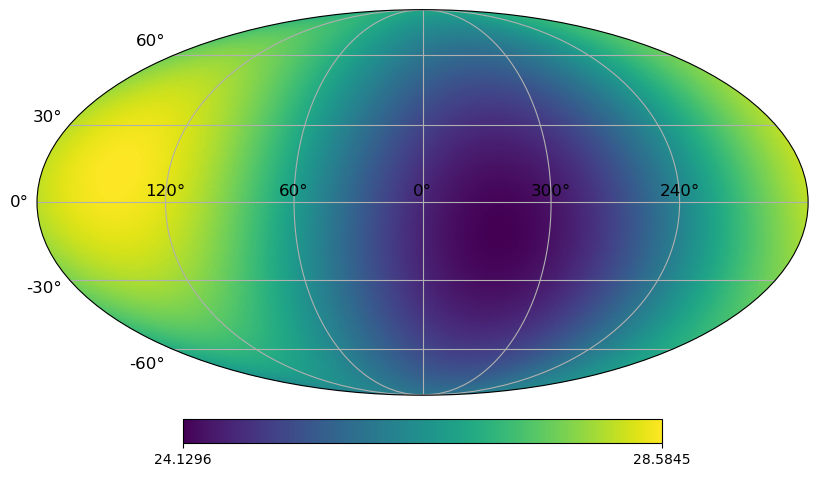

In [86]:
tools.plot_map(map_quaia.astype('float')-map_quaia_nodipole)